<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-1" data-toc-modified-id="Dataset-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset 1</a></span><ul class="toc-item"><li><span><a href="#Lendo-Arquivo" data-toc-modified-id="Lendo-Arquivo-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Lendo Arquivo</a></span></li><li><span><a href="#Visualizando-os-Dados" data-toc-modified-id="Visualizando-os-Dados-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualizando os Dados</a></span></li><li><span><a href="#Treinando-um-Modelo-SVM" data-toc-modified-id="Treinando-um-Modelo-SVM-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Treinando um Modelo SVM</a></span></li><li><span><a href="#Gaussian-Kernel" data-toc-modified-id="Gaussian-Kernel-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Gaussian Kernel</a></span></li></ul></li><li><span><a href="#Dataset-2" data-toc-modified-id="Dataset-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset 2</a></span><ul class="toc-item"><li><span><a href="#Lendo-Arquivo" data-toc-modified-id="Lendo-Arquivo-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Lendo Arquivo</a></span></li><li><span><a href="#Visualizando-Dados" data-toc-modified-id="Visualizando-Dados-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Visualizando Dados</a></span></li><li><span><a href="#Treinando-um-Modelo-SVM" data-toc-modified-id="Treinando-um-Modelo-SVM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Treinando um Modelo SVM</a></span></li></ul></li><li><span><a href="#Dataset-3" data-toc-modified-id="Dataset-3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset 3</a></span><ul class="toc-item"><li><span><a href="#Lendo-os-Dados" data-toc-modified-id="Lendo-os-Dados-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Lendo os Dados</a></span></li><li><span><a href="#Pipeline-para-Melhores-Parâmetros" data-toc-modified-id="Pipeline-para-Melhores-Parâmetros-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Pipeline para Melhores Parâmetros</a></span></li><li><span><a href="#Melhores-Parâmetros" data-toc-modified-id="Melhores-Parâmetros-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Melhores Parâmetros</a></span></li></ul></li><li><span><a href="#Spam-Classifier" data-toc-modified-id="Spam-Classifier-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Spam Classifier</a></span></li></ul></div>

# Exercício 6 - SVM

Notebook criado para armazenar as implementações utilizadas no exercício 6 do curso Introdução a Machine Learning, de Andrew Ng.

## Dataset 1

### Lendo Arquivo

In [1]:
# Lendo arquivo
load('ex6data1.mat')

In [2]:
# Verificando dados lidos
fprintf('Dimensões das features X: (%d, %d)\n', size(X, 1), size(X, 2))
fprintf('Dimensões do set de target y: (%d, %d)\n', size(y, 1), size(y, 2))

Dimensões das features X: (51, 2)
Dimensões do set de target y: (51, 1)


### Visualizando os Dados

In [3]:
# Criando função para visualizar os dados
function plotData(X, y)
    % Função responsável pela visualização dos dados
    
    % Find Indices of Positive and Negative Examples
    pos = find(y == 1); neg = find(y == 0);

    % Plot Examples
    plot(X(pos, 1), X(pos, 2), 'k+','LineWidth', 1, 'MarkerSize', 7)
    hold on;
    plot(X(neg, 1), X(neg, 2), 'ko', 'MarkerFaceColor', 'y', 'MarkerSize', 7)
    hold off;
endfunction

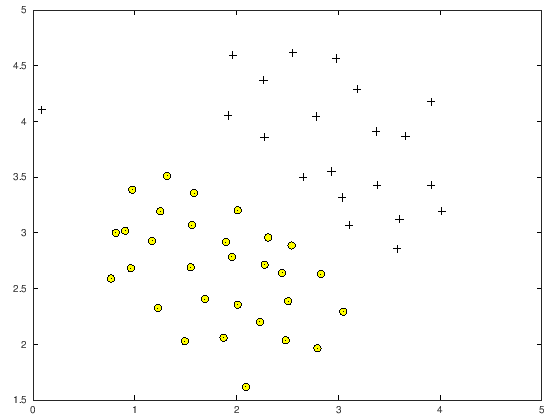

In [4]:
# Visualizando os dados
plotData(X, y)

Um detalhe extremamente interessante a ser citado é um outlier em um dos exemplos positivos (aproximadamente em (0.1, 0.4)). Com isso, será possível verificar os efeitos do modelo ```SVM``` a partir de seu hiperparâmetro ```C``` que, por sua vez, controla a penalidade de exemplos classificados erroneamente.

### Treinando um Modelo SVM

In [5]:
# Definindo função para treinar modelo SVM
function [model] = svmTrain(X, Y, C, kernelFunction, ...
                            tol, max_passes)
%SVMTRAIN Trains an SVM classifier using a simplified version of the SMO 
%algorithm. 
%   [model] = SVMTRAIN(X, Y, C, kernelFunction, tol, max_passes) trains an
%   SVM classifier and returns trained model. X is the matrix of training 
%   examples.  Each row is a training example, and the jth column holds the 
%   jth feature.  Y is a column matrix containing 1 for positive examples 
%   and 0 for negative examples.  C is the standard SVM regularization 
%   parameter.  tol is a tolerance value used for determining equality of 
%   floating point numbers. max_passes controls the number of iterations
%   over the dataset (without changes to alpha) before the algorithm quits.
%
% Note: This is a simplified version of the SMO algorithm for training
%       SVMs. In practice, if you want to train an SVM classifier, we
%       recommend using an optimized package such as:  
%
%           LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
%           SVMLight (http://svmlight.joachims.org/)
%
%

if ~exist('tol', 'var') || isempty(tol)
    tol = 1e-3;
end

if ~exist('max_passes', 'var') || isempty(max_passes)
    max_passes = 5;
end

% Data parameters
m = size(X, 1);
n = size(X, 2);

% Map 0 to -1
Y(Y==0) = -1;

% Variables
alphas = zeros(m, 1);
b = 0;
E = zeros(m, 1);
passes = 0;
eta = 0;
L = 0;
H = 0;

% Pre-compute the Kernel Matrix since our dataset is small
% (in practice, optimized SVM packages that handle large datasets
%  gracefully will _not_ do this)
% 
% We have implemented optimized vectorized version of the Kernels here so
% that the svm training will run faster.
if strcmp(func2str(kernelFunction), 'linearKernel')
    % Vectorized computation for the Linear Kernel
    % This is equivalent to computing the kernel on every pair of examples
    K = X*X';
elseif strfind(func2str(kernelFunction), 'gaussianKernel')
    % Vectorized RBF Kernel
    % This is equivalent to computing the kernel on every pair of examples
    X2 = sum(X.^2, 2);
    K = bsxfun(@plus, X2, bsxfun(@plus, X2', - 2 * (X * X')));
    K = kernelFunction(1, 0) .^ K;
else
    % Pre-compute the Kernel Matrix
    % The following can be slow due to the lack of vectorization
    K = zeros(m);
    for i = 1:m
        for j = i:m
             K(i,j) = kernelFunction(X(i,:)', X(j,:)');
             K(j,i) = K(i,j); %the matrix is symmetric
        end
    end
end

% Train
fprintf('\nTraining ...');
dots = 12;
while passes < max_passes,
            
    num_changed_alphas = 0;
    for i = 1:m,
        
        % Calculate Ei = f(x(i)) - y(i) using (2). 
        % E(i) = b + sum (X(i, :) * (repmat(alphas.*Y,1,n).*X)') - Y(i);
        E(i) = b + sum (alphas.*Y.*K(:,i)) - Y(i);
        
        if ((Y(i)*E(i) < -tol && alphas(i) < C) || (Y(i)*E(i) > tol && alphas(i) > 0)),
            
            % In practice, there are many heuristics one can use to select
            % the i and j. In this simplified code, we select them randomly.
            j = ceil(m * rand());
            while j == i,  % Make sure i \neq j
                j = ceil(m * rand());
            end

            % Calculate Ej = f(x(j)) - y(j) using (2).
            E(j) = b + sum (alphas.*Y.*K(:,j)) - Y(j);

            % Save old alphas
            alpha_i_old = alphas(i);
            alpha_j_old = alphas(j);
            
            % Compute L and H by (10) or (11). 
            if (Y(i) == Y(j)),
                L = max(0, alphas(j) + alphas(i) - C);
                H = min(C, alphas(j) + alphas(i));
            else
                L = max(0, alphas(j) - alphas(i));
                H = min(C, C + alphas(j) - alphas(i));
            end
           
            if (L == H),
                % continue to next i. 
                continue;
            end

            % Compute eta by (14).
            eta = 2 * K(i,j) - K(i,i) - K(j,j);
            if (eta >= 0),
                % continue to next i. 
                continue;
            end
            
            % Compute and clip new value for alpha j using (12) and (15).
            alphas(j) = alphas(j) - (Y(j) * (E(i) - E(j))) / eta;
            
            % Clip
            alphas(j) = min (H, alphas(j));
            alphas(j) = max (L, alphas(j));
            
            % Check if change in alpha is significant
            if (abs(alphas(j) - alpha_j_old) < tol),
                % continue to next i. 
                % replace anyway
                alphas(j) = alpha_j_old;
                continue;
            end
            
            % Determine value for alpha i using (16). 
            alphas(i) = alphas(i) + Y(i)*Y(j)*(alpha_j_old - alphas(j));
            
            % Compute b1 and b2 using (17) and (18) respectively. 
            b1 = b - E(i) ...
                 - Y(i) * (alphas(i) - alpha_i_old) *  K(i,j)' ...
                 - Y(j) * (alphas(j) - alpha_j_old) *  K(i,j)';
            b2 = b - E(j) ...
                 - Y(i) * (alphas(i) - alpha_i_old) *  K(i,j)' ...
                 - Y(j) * (alphas(j) - alpha_j_old) *  K(j,j)';

            % Compute b by (19). 
            if (0 < alphas(i) && alphas(i) < C),
                b = b1;
            elseif (0 < alphas(j) && alphas(j) < C),
                b = b2;
            else
                b = (b1+b2)/2;
            end

            num_changed_alphas = num_changed_alphas + 1;

        end
        
    end
    
    if (num_changed_alphas == 0),
        passes = passes + 1;
    else
        passes = 0;
    end

    fprintf('.');
    dots = dots + 1;
    if dots > 78
        dots = 0;
        fprintf('\n');
    end
    if exist('OCTAVE_VERSION')
        fflush(stdout);
    end
end
fprintf(' Done! \n\n');

% Save the model
idx = alphas > 0;
model.X= X(idx,:);
model.y= Y(idx);
model.kernelFunction = kernelFunction;
model.b= b;
model.alphas= alphas(idx);
model.w = ((alphas.*Y)'*X)';

end

In [6]:
# Definindo função de Kernel
function sim = linearKernel(x1, x2)
%LINEARKERNEL returns a linear kernel between x1 and x2
%   sim = linearKernel(x1, x2) returns a linear kernel between x1 and x2
%   and returns the value in sim

% Ensure that x1 and x2 are column vectors
x1 = x1(:); x2 = x2(:);

% Compute the kernel
sim = x1' * x2;  % dot product

end

In [7]:
# Treinando modelo com C = 1
C = 1;
model = svmTrain(X, y, C, @linearKernel, 1e-3, 20);


Training ......................................................................
...............................................................................
..... Done! 



In [8]:
# Definindo função para visualizar os dados
function visualizeBoundaryLinear(X, y, model)
%VISUALIZEBOUNDARYLINEAR plots a linear decision boundary learned by the
%SVM
%   VISUALIZEBOUNDARYLINEAR(X, y, model) plots a linear decision boundary 
%   learned by the SVM and overlays the data on it

w = model.w;
b = model.b;
xp = linspace(min(X(:,1)), max(X(:,1)), 100);
yp = - (w(1)*xp + b)/w(2);
plotData(X, y);
hold on;
plot(xp, yp, '-b'); 
hold off

end

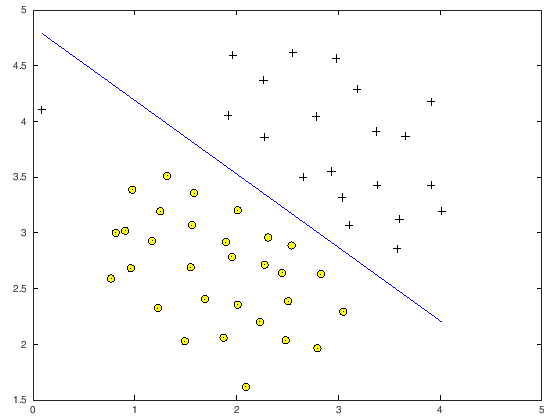

In [9]:
# Visualizando dados
visualizeBoundaryLinear(X, y, model)

Lembrando da teoria:
    * Com o hiperparâmetro C baixo, o modelo fica menos sensível a outliers, apresentando uma menor variância e um maior bias

### Gaussian Kernel

In [10]:
# Testes para implementação de Gaussian Kernel
x1 = [1 2 1] 
x2 = [0 4 -1] 
sigma = 2;

x1 =

   1   2   1

x2 =

   0   4  -1



In [11]:
# Transformando em vetor de coluna
x1 = x1(:)
x2 = x2(:)

x1 =

   1
   2
   1

x2 =

   0
   4
  -1



In [12]:
# Testando subtração
x1 - x2

ans =

   1
  -2
   2



In [13]:
# Elevando tudo ao quadrado
(x1 - x2).^2

ans =

   1
   4
   4



In [14]:
# Somando termos
sum((x1 - x2).^2)

ans =  9


In [15]:
# Dividindo por sigma quadrado
sum((x1 - x2).^2) / sigma^2

ans =  2.2500


In [16]:
# Aplicando exponencial
exp(-sum((x1 - x2).^2) / sigma^2)

ans =  0.10540


In [17]:
exp(0)

ans =  1


In [18]:
exp(-2.25)

ans =  0.10540


Deu errado! Aparentemente, é necessário dividir por sigma e depois aplicar a soma

In [19]:
exp(-sum(((x1 - x2).^2/sigma^2)))

ans =  0.10540


Erro! Acredito que seja necessário aplicar feature scaling antes.

In [20]:
# Aplicando normalização
x1_scaled = (x1.-mean(x1)) / std(x1)
x2_scaled = (x2.-mean(x2)) / std(x2)

x1_scaled =

  -0.57735
   1.15470
  -0.57735

x2_scaled =

  -0.37796
   1.13389
  -0.75593



In [21]:
# Aplicando Gaussian Kernel novamente
exp(-sum(((x1_scaled - x2_scaled).^2/sigma^2)))

ans =  0.98214


Não era nada disso! **Faltou apenas multiplicar sigma por 2**

In [22]:
# Gaussian Kernel definitivo
exp(-sum(((x1 - x2).^2/(2*(sigma^2)))))

ans =  0.32465


Perfeito! Basta definir a função.

In [23]:
# Definindo função
function sim = gaussianKernel(x1, x2, sigma)
    
    % Transformando dados em vetor com uma coluna apenas
    x1 = x1(:);
    x2 = x2(:);
    
    sim = exp(-sum(((x1 - x2).^2/(2*(sigma^2)))));
    
endfunction

## Dataset 2

### Lendo Arquivo

In [24]:
# Lendo arquivo
load('ex6data2.mat')

In [25]:
# Verificando dimensões
size(X)
size(y)

ans =

   863     2

ans =

   863     1



In [26]:
# Comunicando resultado
fprintf('O dataset 2 possui %d linhas e %d colunas\n', size(X, 1), size(X, 2))

O dataset 2 possui 863 linhas e 2 colunas


### Visualizando Dados

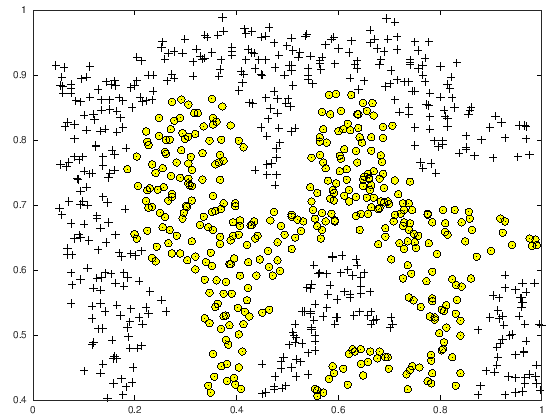

In [27]:
# Chamando função de plotagem
plotData(X, y)

Trata-se de um problema cuja função não é linear.

In [28]:
# Implementando função para visualização de função hypothesis não linear
function visualizeBoundary(X, y, model, varargin)
%VISUALIZEBOUNDARY plots a non-linear decision boundary learned by the SVM
%   VISUALIZEBOUNDARYLINEAR(X, y, model) plots a non-linear decision 
%   boundary learned by the SVM and overlays the data on it

% Plot the training data on top of the boundary
plotData(X, y)

% Make classification predictions over a grid of values
x1plot = linspace(min(X(:,1)), max(X(:,1)), 100)';
x2plot = linspace(min(X(:,2)), max(X(:,2)), 100)';
[X1, X2] = meshgrid(x1plot, x2plot);
vals = zeros(size(X1));
for i = 1:size(X1, 2)
   this_X = [X1(:, i), X2(:, i)];
   vals(:, i) = svmPredict(model, this_X);
end

% Plot the SVM boundary
hold on
contour(X1, X2, vals, [0.5 0.5], 'b');
hold off;

end

### Treinando um Modelo SVM


Training ......................................................................
........ Done! 

error: 'svmPredict' undefined near line 16 column 17
error: called from
    visualizeBoundary at line 16 column 15


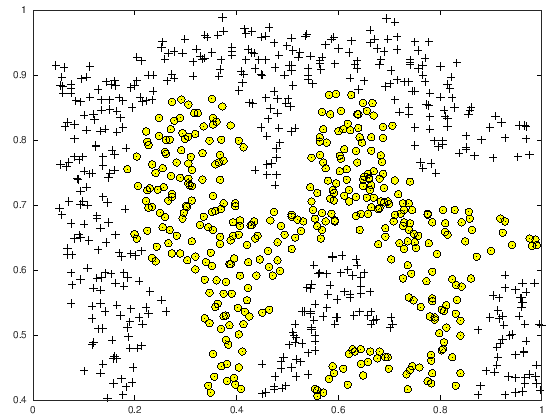

In [29]:
# Treinando modelo e visualizando função
model = svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma)); 
visualizeBoundary(X, y, model);

In [30]:
# Implementando função para predizer os dados
function pred = svmPredict(model, X)
%SVMPREDICT returns a vector of predictions using a trained SVM model
%(svmTrain). 
%   pred = SVMPREDICT(model, X) returns a vector of predictions using a 
%   trained SVM model (svmTrain). X is a mxn matrix where there each 
%   example is a row. model is a svm model returned from svmTrain.
%   predictions pred is a m x 1 column of predictions of {0, 1} values.
%

% Check if we are getting a column vector, if so, then assume that we only
% need to do prediction for a single example
if (size(X, 2) == 1)
    % Examples should be in rows
    X = X';
end

% Dataset 
m = size(X, 1);
p = zeros(m, 1);
pred = zeros(m, 1);

if strcmp(func2str(model.kernelFunction), 'linearKernel')
    % We can use the weights and bias directly if working with the 
    % linear kernel
    p = X * model.w + model.b;
elseif strfind(func2str(model.kernelFunction), 'gaussianKernel')
    % Vectorized RBF Kernel
    % This is equivalent to computing the kernel on every pair of examples
    X1 = sum(X.^2, 2);
    X2 = sum(model.X.^2, 2)';
    K = bsxfun(@plus, X1, bsxfun(@plus, X2, - 2 * X * model.X'));
    K = model.kernelFunction(1, 0) .^ K;
    K = bsxfun(@times, model.y', K);
    K = bsxfun(@times, model.alphas', K);
    p = sum(K, 2);
else
    % Other Non-linear kernel
    for i = 1:m
        prediction = 0;
        for j = 1:size(model.X, 1)
            prediction = prediction + ...
                model.alphas(j) * model.y(j) * ...
                model.kernelFunction(X(i,:)', model.X(j,:)');
        end
        p(i) = prediction + model.b;
    end
end

% Convert predictions into 0 / 1
pred(p >= 0) =  1;
pred(p <  0) =  0;

end


Training ......................................................................
............................................. Done! 



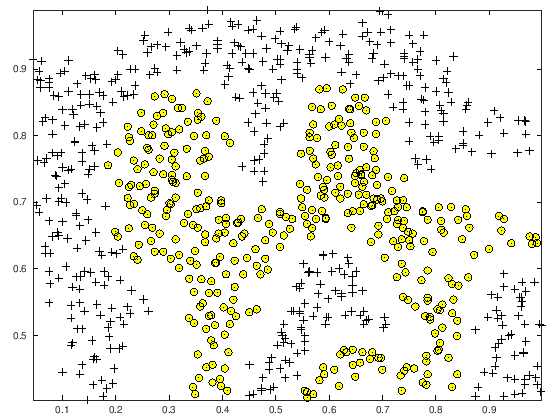

In [31]:
% Treinando novamente e visualizando
model = svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma)); 
visualizeBoundary(X, y, model);

Por algum motivo, a curva que define a função hipótese não foi plotada.

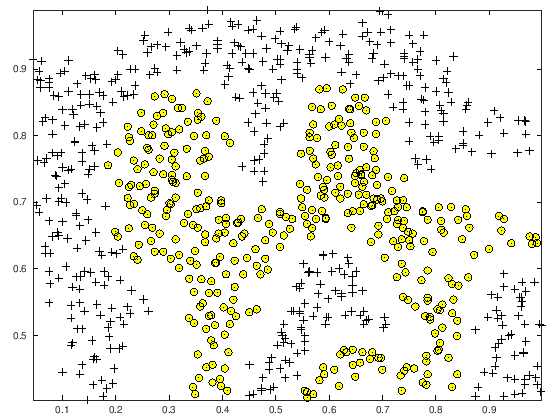

In [32]:
visualizeBoundary(X, y, model)

## Dataset 3

### Lendo os Dados

In [33]:
# Lendo dados
load('ex6data3.mat')

In [34]:
# Dimensões
size(X)
size(y)

ans =

   211     2

ans =

   211     1



Parece que também há dados de validação ```Xval``` e ```yval```.

In [35]:
size(Xval)
size(yval)

ans =

   200     2

ans =

   200     1



Será necessário criar uma função que retorne os parâmetros ótimos para ```C``` e ```sigma```, ou seja, o combinado que apresenta o menor erro de predição para os dados de validação.

Pipeline:
    * Escolher valores específicos para os parâmetros;
    * Treinar o modelo com os dados de treino;
    * Realizar predições com os dados de validação;
    * Mensurar performance do modelo.

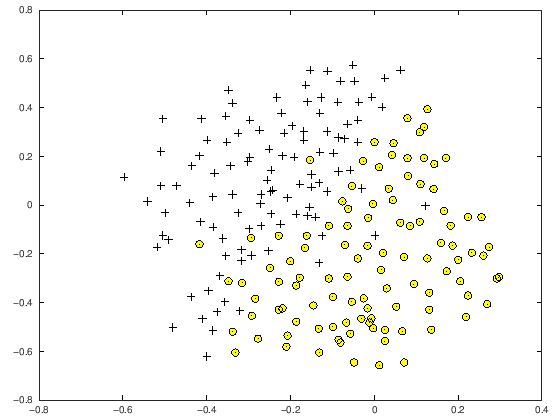

In [36]:
# Plotando dados
plotData(X, y)

O gráfico acima indica que talvez uma linha reta (parâmetro C bem baixo) talvez não seja a melhor opção.


Training ......................................................................
...............................................................................
............................................................................. Done! 



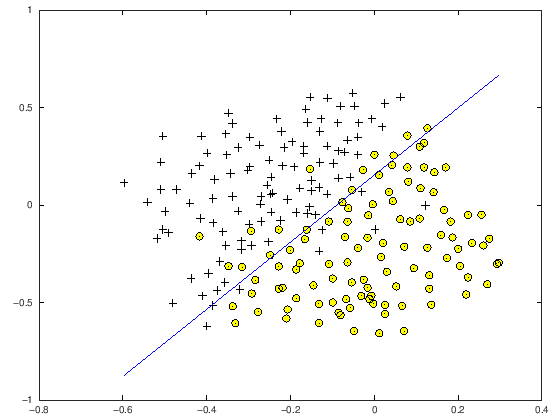

In [37]:
# Testando cálculo de erro através do pipeline definido
C = 1;
sigma = 0.3;

model = svmTrain(X, y, C, @linearKernel, 1e-3, 20);
visualizeBoundaryLinear(X, y, model)

Bom... é possível melhorar. Vamos retornar um valor para servir de métrica de performance para este treinamento.

In [38]:
# Mensurando performance
predictions = svmPredict(model, Xval);
performance = mean(double(predictions ~= yval))
fprintf('Erro do modelo com C=%d e sigma=%d: %.4f\n', C, sigma, performance)

performance =  0.075000
Erro do modelo com C=1 e sigma=0.3: 0.0750



Training ......................................................................
...............................................................................
...............................................................................
...............................................................................
................................. Done! 



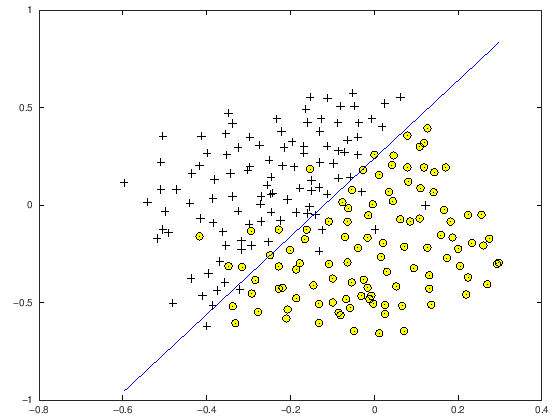

In [39]:
C = 10;
sigma = 0.5;
model = svmTrain(X, y, C, @linearKernel, 1e-3, 20);
visualizeBoundaryLinear(X, y, model)

In [40]:
# Mensurando performance
predictions = svmPredict(model, Xval);
performance = mean(double(predictions ~= yval))
fprintf('Erro do modelo com C=%d e sigma=%d: %.4f\n', C, sigma, performance)

performance =  0.065000
Erro do modelo com C=10 e sigma=0.5: 0.0650


Acredito que a ideia seja utilizar ```Gaussian Kernel ```


Training ......................................................................
............................................................... Done! 



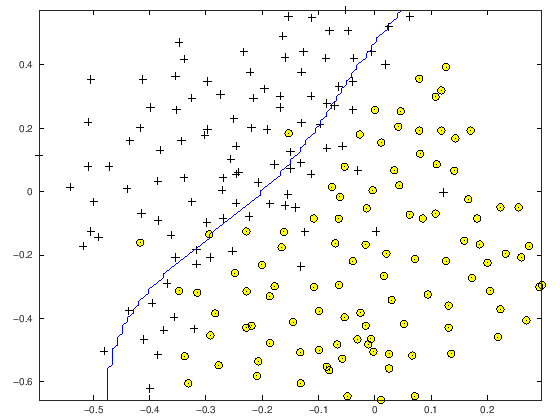

In [41]:
model = svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma)); 
visualizeBoundary(X, y, model);

### Pipeline para Melhores Parâmetros

In [42]:
function bestParams(C, sigma, X, y, Xval, yval)
    
    % Treinando modelo
    model = svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma)); 
    
    % Visualizando resultado
    visualizeBoundary(X, y, model);
    
    % Avaliando performance
    predictions = svmPredict(model, Xval);
    performance = mean(double(predictions ~= yval));
    fprintf('Erro do modelo com C=%d e sigma=%d: %.4f\n', C, sigma, performance);
    
endfunction


Training ......................................................................
....................... Done! 

Erro do modelo com C=5 e sigma=1: 0.0800


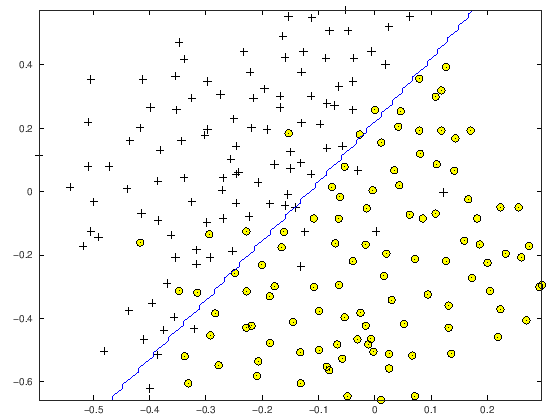

In [43]:
# Executando função
C = 5;
sigma = 1;
bestParams(C, sigma, X, y, Xval, yval);

Verificando valores sugeridos pelo instrutor para ```C``` e ```sigma```:

0.01; 0.03; 0.1; 0.3; 1; 3; 10; 30

In [44]:
params_values = [0.01; 0.03; 0.1; 0.3; 1; 3; 10; 30]

params_values =

    0.010000
    0.030000
    0.100000
    0.300000
    1.000000
    3.000000
   10.000000
   30.000000



In [45]:
for i = 1:length(params_values)
    fprintf('%d\n', params_values(i))
endfor

0.01
0.03
0.1
0.3
1
3
10
30


In [46]:
# Realizando treinamento
j = 1;
k = 1;
predictions = zeros(64, 1);
for i = 1:length(predictions)
    C = params_values(j)
    sigma = params_values(k)
    model = svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma));
    y_pred = svmPredict(model, Xval);
    performance = mean(double(y_pred ~= yval));
    predictions(i) = performance;
    
    k = k + 1;
    
    if k == 9
        k = 1;
        j = j + 1;
    endif
    
    if j == 9;
        break
    endif
    
endfor

C =  0.010000
sigma =  0.010000

Training ......... Done! 

C =  0.010000
sigma =  0.030000

Training ................................................ Done! 

C =  0.010000
sigma =  0.10000

Training ..................................... Done! 

C =  0.010000
sigma =  0.30000

Training ............................... Done! 

C =  0.010000
sigma =  1

Training ........................................... Done! 

C =  0.010000
sigma =  3

Training ...................... Done! 

C =  0.010000
sigma =  10

Training ................................ Done! 

C =  0.010000
sigma =  30

Training ................................................ Done! 

C =  0.030000
sigma =  0.010000

Training ......... Done! 

C =  0.030000
sigma =  0.030000

Training ............................................................... Done! 

C =  0.030000
sigma =  0.10000

Training ..................................................... Done! 

C =  0.030000
sigma =  0.30000

Training ................................

...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
............. Done! 

C =  30
sigma =  0

In [47]:
predictions

predictions =

   0.565000
   0.060000
   0.045000
   0.145000
   0.180000
   0.180000
   0.180000
   0.180000
   0.565000
   0.060000
   0.045000
   0.140000
   0.185000
   0.180000
   0.180000
   0.180000
   0.565000
   0.060000
   0.045000
   0.080000
   0.170000
   0.185000
   0.180000
   0.185000
   0.565000
   0.060000
   0.035000
   0.065000
   0.095000
   0.185000
   0.185000
   0.185000
   0.565000
   0.065000
   0.030000
   0.070000
   0.080000
   0.150000
   0.185000
   0.185000
   0.565000
   0.080000
   0.035000
   0.080000
   0.085000
   0.100000
   0.180000
   0.185000
   0.565000
   0.080000
   0.070000
   0.070000
   0.080000
   0.075000
   0.165000
   0.185000
   0.565000
   0.080000
   0.060000
   0.060000
   0.105000
   0.090000
   0.095000
   0.185000



In [48]:
min(predictions)

ans =  0.030000


In [49]:
% Pensando em uma outra forma
predictions = zeros(64, 1)
predictions(1) = 1

predictions =

   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0

predictions =

   1
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0



A ideia é salvar, a cada iteração, os valores de C e sigma.

In [50]:
predictions = zeros(64)(1:5, 1:3)

predictions =

   0   0   0
   0   0   0
   0   0   0
   0   0   0
   0   0   0



In [51]:
predictions(1) = 1;
predictions(1:5, :)

ans =

   1   0   0
   0   0   0
   0   0   0
   0   0   0
   0   0   0



In [52]:
predictions(2) = 5;
predictions(1:5, :)

ans =

   1   0   0
   5   0   0
   0   0   0
   0   0   0
   0   0   0



In [53]:
predictions(67) = 7;
predictions(1:5, :)

error: Invalid resizing operation or ambiguous assignment to an out-of-bounds array element
ans =

   1   0   0
   5   0   0
   0   0   0
   0   0   0
   0   0   0



Para salvar parâmetros em outras colunas, basta somar 64 e 128 no índice

In [54]:
predictions(129) = 10;
predictions(1:5, :)

error: Invalid resizing operation or ambiguous assignment to an out-of-bounds array element
ans =

   1   0   0
   5   0   0
   0   0   0
   0   0   0
   0   0   0



In [55]:
predictions = zeros(64)(:, 1:3);
size(predictions)

ans =

   64    3



In [56]:
# Treinando novamente o modelo e salvando os parâmetros
j = 1;
k = 1;
predictions = zeros(64)(:, 1:3);
for i = 1:length(predictions)
    C = params_values(j)
    sigma = params_values(k)
    model = svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma));
    y_pred = svmPredict(model, Xval);
    performance = mean(double(y_pred ~= yval));
    
    predictions(i) = performance;
    predictions(i+64) = C;
    predictions(i+128) = sigma;
    
    k = k + 1;
    
    if k == 9
        k = 1;
        j = j + 1;
    endif
    
    if j == 9;
        break
    endif
    
endfor

C =  0.010000
sigma =  0.010000

Training ......... Done! 

C =  0.010000
sigma =  0.030000

Training ............................................... Done! 

C =  0.010000
sigma =  0.10000

Training ...................................................... Done! 

C =  0.010000
sigma =  0.30000

Training ................................ Done! 

C =  0.010000
sigma =  1

Training ................................................. Done! 

C =  0.010000
sigma =  3

Training .................................................................... Done! 

C =  0.010000
sigma =  10

Training ........................................ Done! 

C =  0.010000
sigma =  30

Training .................................... Done! 

C =  0.030000
sigma =  0.010000

Training ......... Done! 

C =  0.030000
sigma =  0.030000

Training ......................................................................
.. Done! 

C =  0.030000
sigma =  0.10000

Training ................................................... Done! 




Training ......................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

Verificando matriz obtida.

* Coluna 1 - Erro
* Coluna 2 - C
* Coluna 3 - sigma

In [57]:
# Matriz
predictions

predictions =

    0.565000    0.010000    0.010000
    0.060000    0.010000    0.030000
    0.045000    0.010000    0.100000
    0.145000    0.010000    0.300000
    0.180000    0.010000    1.000000
    0.185000    0.010000    3.000000
    0.180000    0.010000   10.000000
    0.180000    0.010000   30.000000
    0.565000    0.030000    0.010000
    0.060000    0.030000    0.030000
    0.045000    0.030000    0.100000
    0.140000    0.030000    0.300000
    0.180000    0.030000    1.000000
    0.185000    0.030000    3.000000
    0.185000    0.030000   10.000000
    0.180000    0.030000   30.000000
    0.565000    0.100000    0.010000
    0.060000    0.100000    0.030000
    0.045000    0.100000    0.100000
    0.075000    0.100000    0.300000
    0.170000    0.100000    1.000000
    0.185000    0.100000    3.000000
    0.180000    0.100000   10.000000
    0.180000    0.100000   30.000000
    0.565000    0.300000    0.010000
    0.060000    0.300000    0.030000
    0.035000    0.30000

In [58]:
menor_erro = min(predictions(:, 1))

menor_erro =  0.030000


In [59]:
help find

'find' is a built-in function from the file libinterp/corefcn/find.cc

 -- IDX = find (X)
 -- IDX = find (X, N)
 -- IDX = find (X, N, DIRECTION)
 -- [i, j] = find (...)
 -- [i, j, v] = find (...)
     Return a vector of indices of nonzero elements of a matrix, as a
     row if X is a row vector or as a column otherwise.

     To obtain a single index for each matrix element, Octave pretends
     that the columns of a matrix form one long vector (like Fortran
     arrays are stored).  For example:

          find (eye (2))
            => [ 1; 4 ]

     If two inputs are given, N indicates the maximum number of elements
     to find from the beginning of the matrix or vector.

     If three inputs are given, DIRECTION should be one of "first" or
     "last", requesting only the first or last N indices, respectively.
     However, the indices are always returned in ascending order.

     If two outputs are requested, 'find' returns the row and column
     indices of nonzero elements of a 

In [60]:
find(menor_erro)

ans =  1


Visualmente, é possível ver que o menor erro é ```0,03``` com C = ```1``` e sigma = ```0,1```

In [61]:
predictions(predictions == menor_erro)

ans =

   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000
   0.030000



### Melhores Parâmetros

O melhor jeito é realizar uma verificação através de um if, para assim retornar os parâmetros C e sigma caso o erro seja o menor a cada iteração.

In [62]:
# Treinando novamente o modelo e salvando os parâmetros
j = 1;
k = 1;
predictions = zeros(64)(:, 1:3);
lowest_error = 1;
best_C = 0;
best_sigma = 0;

for i = 1:length(predictions)
    C = params_values(j)
    sigma = params_values(k)
    model = svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma));
    y_pred = svmPredict(model, Xval);
    performance = mean(double(y_pred ~= yval));
    
    predictions(i) = performance;
    predictions(i+64) = C;
    predictions(i+128) = sigma;
    
    if performance < lowest_error
        lowest_error = performance;
        best_C = C;
        best_sigma = sigma;
    endif
    
    k = k + 1;
    
    if k == 9
        k = 1;
        j = j + 1;
    endif
    
    if j == 9;
        break
    endif
    
endfor

C =  0.010000
sigma =  0.010000

Training ......... Done! 

C =  0.010000
sigma =  0.030000

Training .................................................. Done! 

C =  0.010000
sigma =  0.10000

Training ......................................................................
........ Done! 

C =  0.010000
sigma =  0.30000

Training ................................... Done! 

C =  0.010000
sigma =  1

Training .......................... Done! 

C =  0.010000
sigma =  3

Training ........................................... Done! 

C =  0.010000
sigma =  10

Training ............................................ Done! 

C =  0.010000
sigma =  30

Training ................................................... Done! 

C =  0.030000
sigma =  0.010000

Training ......... Done! 

C =  0.030000
sigma =  0.030000

Training ............................................................. Done! 

C =  0.030000
sigma =  0.10000

Training ....................................................... Done! 

C =  0

...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
............................................................ Done! 

C =  30
sigma =  0.30000

Training ......................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.........................

In [63]:
lowest_error
best_C
best_sigma

lowest_error =  0.030000
best_C =  1
best_sigma =  0.10000


In [64]:
predictions

predictions =

    0.565000    0.010000    0.010000
    0.060000    0.010000    0.030000
    0.045000    0.010000    0.100000
    0.145000    0.010000    0.300000
    0.185000    0.010000    1.000000
    0.185000    0.010000    3.000000
    0.185000    0.010000   10.000000
    0.180000    0.010000   30.000000
    0.565000    0.030000    0.010000
    0.060000    0.030000    0.030000
    0.045000    0.030000    0.100000
    0.140000    0.030000    0.300000
    0.180000    0.030000    1.000000
    0.185000    0.030000    3.000000
    0.185000    0.030000   10.000000
    0.180000    0.030000   30.000000
    0.565000    0.100000    0.010000
    0.060000    0.100000    0.030000
    0.045000    0.100000    0.100000
    0.080000    0.100000    0.300000
    0.175000    0.100000    1.000000
    0.180000    0.100000    3.000000
    0.185000    0.100000   10.000000
    0.185000    0.100000   30.000000
    0.565000    0.300000    0.010000
    0.060000    0.300000    0.030000
    0.035000    0.30000

Ótimo, parece que deu certo. O menor erro é 0.03 com C=1 e sigma=0.1


Training ......................................................................
...............................................................................
...............................................................................
............... Done! 

Erro do modelo com C=1 e sigma=0.1: 0.0300


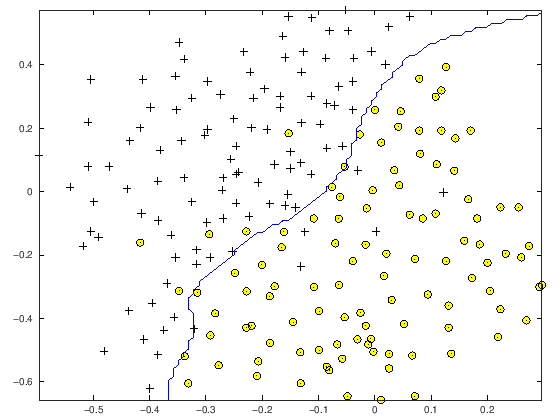

In [65]:
# Visualizando
bestParams(best_C, best_sigma, X, y, Xval, yval);

C =  5
sigma =  1

Training ......................................................................
.............................................................. Done! 

Erro do modelo com C=5 e sigma=1: 0.0750


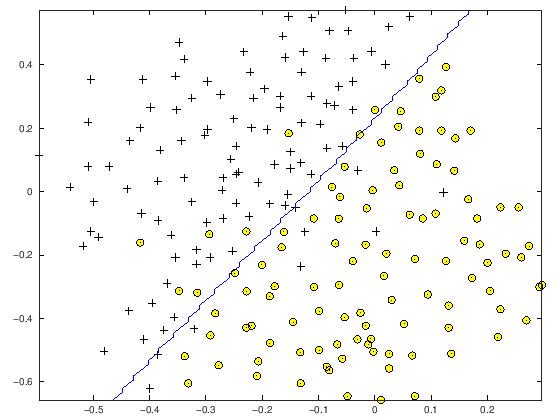

In [67]:
% Comparando com outros valores de C e sigma
C = 5
sigma = 1
bestParams(C, sigma, X, y, Xval, yval);

## Spam Classifier

In [69]:
# Criando função para ler arquivos de email
function file_contents = readFile(filename)
%READFILE reads a file and returns its entire contents 
%   file_contents = READFILE(filename) reads a file and returns its entire
%   contents in file_contents
%

% Load File
fid = fopen(filename);
if fid
    file_contents = fscanf(fid, '%c', inf);
    fclose(fid);
else
    file_contents = '';
    fprintf('Unable to open %s\n', filename);
end

end

In [71]:
file_contents = readFile('emailSample1.txt');

In [73]:
# Vejamos um exemplo de email
file_contents

file_contents = > Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




Função para processar o email.


In [74]:
function word_indices = processEmail(email_contents)
%PROCESSEMAIL preprocesses a the body of an email and
%returns a list of word_indices 
%   word_indices = PROCESSEMAIL(email_contents) preprocesses 
%   the body of an email and returns a list of indices of the 
%   words contained in the email. 
%

% Load Vocabulary
vocabList = getVocabList();

% Init return value
word_indices = [];

% ========================== Preprocess Email ===========================

% Find the Headers ( \n\n and remove )
% Uncomment the following lines if you are working with raw emails with the
% full headers

% hdrstart = strfind(email_contents, ([char(10) char(10)]));
% email_contents = email_contents(hdrstart(1):end);

% Lower case
email_contents = lower(email_contents);

% Strip all HTML
% Looks for any expression that starts with < and ends with > and replace
% and does not have any < or > in the tag it with a space
email_contents = regexprep(email_contents, '<[^<>]+>', ' ');

% Handle Numbers
% Look for one or more characters between 0-9
email_contents = regexprep(email_contents, '[0-9]+', 'number');

% Handle URLS
% Look for strings starting with http:// or https://
email_contents = regexprep(email_contents, ...
                           '(http|https)://[^\s]*', 'httpaddr');

% Handle Email Addresses
% Look for strings with @ in the middle
email_contents = regexprep(email_contents, '[^\s]+@[^\s]+', 'emailaddr');

% Handle $ sign
email_contents = regexprep(email_contents, '[$]+', 'dollar');


% ========================== Tokenize Email ===========================

% Output the email to screen as well
fprintf('\n==== Processed Email ====\n\n');

% Process file
l = 0;

while ~isempty(email_contents)

    % Tokenize and also get rid of any punctuation
    [str, email_contents] = ...
       strtok(email_contents, ...
              [' @$/#.-:&*+=[]?!(){},''">_<;%' char(10) char(13)]);
   
    % Remove any non alphanumeric characters
    str = regexprep(str, '[^a-zA-Z0-9]', '');

    % Stem the word 
    % (the porterStemmer sometimes has issues, so we use a try catch block)
    try str = porterStemmer(strtrim(str)); 
    catch str = ''; continue;
    end;

    % Skip the word if it is too short
    if length(str) < 1
       continue;
    end

    % Look up the word in the dictionary and add to word_indices if
    % found
    % ====================== YOUR CODE HERE ======================
    % Instructions: Fill in this function to add the index of str to
    %               word_indices if it is in the vocabulary. At this point
    %               of the code, you have a stemmed word from the email in
    %               the variable str. You should look up str in the
    %               vocabulary list (vocabList). If a match exists, you
    %               should add the index of the word to the word_indices
    %               vector. Concretely, if str = 'action', then you should
    %               look up the vocabulary list to find where in vocabList
    %               'action' appears. For example, if vocabList{18} =
    %               'action', then, you should add 18 to the word_indices 
    %               vector (e.g., word_indices = [word_indices ; 18]; ).
    % 
    % Note: vocabList{idx} returns a the word with index idx in the
    %       vocabulary list.
    % 
    % Note: You can use strcmp(str1, str2) to compare two strings (str1 and
    %       str2). It will return 1 only if the two strings are equivalent.
    %

    vocabSize = size(vocabList);
    
    for index = 1 : vocabSize,
    	if strcmp(vocabList{index} , str),
    		word_indices = [word_indices ; index]; 
    	end
    end


    % =============================================================


    % Print to screen, ensuring that the output lines are not too long
    if (l + length(str) + 1) > 78
        fprintf('\n');
        l = 0;
    end
    fprintf('%s ', str);
    l = l + length(str) + 1;

end

% Print footer
fprintf('\n\n=========================\n');

end


Função para extração das features

In [75]:
function x = emailFeatures(word_indices)
%EMAILFEATURES takes in a word_indices vector and produces a feature vector
%from the word indices
%   x = EMAILFEATURES(word_indices) takes in a word_indices vector and 
%   produces a feature vector from the word indices. 

% Total number of words in the dictionary
n = 1899;

% You need to return the following variables correctly.
x = zeros(n, 1);

% ====================== YOUR CODE HERE ======================
% Instructions: Fill in this function to return a feature vector for the
%               given email (word_indices). To help make it easier to 
%               process the emails, we have have already pre-processed each
%               email and converted each word in the email into an index in
%               a fixed dictionary (of 1899 words). The variable
%               word_indices contains the list of indices of the words
%               which occur in one email.
% 
%               Concretely, if an email has the text:
%
%                  The quick brown fox jumped over the lazy dog.
%
%               Then, the word_indices vector for this text might look 
%               like:
%               
%                   60  100   33   44   10     53  60  58   5
%
%               where, we have mapped each word onto a number, for example:
%
%                   the   -- 60
%                   quick -- 100
%                   ...
%
%              (note: the above numbers are just an example and are not the
%               actual mappings).
%
%              Your task is take one such word_indices vector and construct
%              a binary feature vector that indicates whether a particular
%              word occurs in the email. That is, x(i) = 1 when word i
%              is present in the email. Concretely, if the word 'the' (say,
%              index 60) appears in the email, then x(60) = 1. The feature
%              vector should look like:
%
%              x = [ 0 0 0 0 1 0 0 0 ... 0 0 0 0 1 ... 0 0 0 1 0 ..];
%
%

for i = word_indices
  x(i) = 1;
end






% =========================================================================
    

end


In [77]:
function vocabList = getVocabList()
%GETVOCABLIST reads the fixed vocabulary list in vocab.txt and returns a
%cell array of the words
%   vocabList = GETVOCABLIST() reads the fixed vocabulary list in vocab.txt 
%   and returns a cell array of the words in vocabList.


%% Read the fixed vocabulary list
fid = fopen('vocab.txt');

% Store all dictionary words in cell array vocab{}
n = 1899;  % Total number of words in the dictionary

% For ease of implementation, we use a struct to map the strings => integers
% In practice, you'll want to use some form of hashmap
vocabList = cell(n, 1);
for i = 1:n
    % Word Index (can ignore since it will be = i)
    fscanf(fid, '%d', 1);
    % Actual Word
    vocabList{i} = fscanf(fid, '%s', 1);
end
fclose(fid);

end

In [ ]:
function stem = porterStemmer(inString)
% Applies the Porter Stemming algorithm as presented in the following
% paper:
% Porter, 1980, An algorithm for suffix stripping, Program, Vol. 14,
%   no. 3, pp 130-137

% Original code modeled after the C version provided at:
% http://www.tartarus.org/~martin/PorterStemmer/c.txt

% The main part of the stemming algorithm starts here. b is an array of
% characters, holding the word to be stemmed. The letters are in b[k0],
% b[k0+1] ending at b[k]. In fact k0 = 1 in this demo program (since
% matlab begins indexing by 1 instead of 0). k is readjusted downwards as
% the stemming progresses. Zero termination is not in fact used in the
% algorithm.

% To call this function, use the string to be stemmed as the input
% argument.  This function returns the stemmed word as a string.

% Lower-case string
inString = lower(inString);

global j;
b = inString;
k = length(b);
k0 = 1;
j = k;



% With this if statement, strings of length 1 or 2 don't go through the
% stemming process. Remove this conditional to match the published
% algorithm.
stem = b;
if k > 2
    % Output displays per step are commented out.
    %disp(sprintf('Word to stem: %s', b));
    x = step1ab(b, k, k0);
    %disp(sprintf('Steps 1A and B yield: %s', x{1}));
    x = step1c(x{1}, x{2}, k0);
    %disp(sprintf('Step 1C yields: %s', x{1}));
    x = step2(x{1}, x{2}, k0);
    %disp(sprintf('Step 2 yields: %s', x{1}));
    x = step3(x{1}, x{2}, k0);
    %disp(sprintf('Step 3 yields: %s', x{1}));
    x = step4(x{1}, x{2}, k0);
    %disp(sprintf('Step 4 yields: %s', x{1}));
    x = step5(x{1}, x{2}, k0);
    %disp(sprintf('Step 5 yields: %s', x{1}));
    stem = x{1};
end

% cons(j) is TRUE <=> b[j] is a consonant.
function c = cons(i, b, k0)
c = true;
switch(b(i))
    case {'a', 'e', 'i', 'o', 'u'}
        c = false;
    case 'y'
        if i == k0
            c = true;
        else
            c = ~cons(i - 1, b, k0);
        end
end

% mseq() measures the number of consonant sequences between k0 and j.  If
% c is a consonant sequence and v a vowel sequence, and <..> indicates
% arbitrary presence,

%      <c><v>       gives 0
%      <c>vc<v>     gives 1
%      <c>vcvc<v>   gives 2
%      <c>vcvcvc<v> gives 3
%      ....
function n = measure(b, k0)
global j;
n = 0;
i = k0;
while true
    if i > j
        return
    end
    if ~cons(i, b, k0)
        break;
    end
    i = i + 1;
end
i = i + 1;
while true
    while true
        if i > j
            return
        end
        if cons(i, b, k0)
            break;
        end
        i = i + 1;
    end
    i = i + 1;
    n = n + 1;
    while true
        if i > j
            return
        end
        if ~cons(i, b, k0)
            break;
        end
        i = i + 1;
    end
    i = i + 1;
end


% vowelinstem() is TRUE <=> k0,...j contains a vowel
function vis = vowelinstem(b, k0)
global j;
for i = k0:j,
    if ~cons(i, b, k0)
        vis = true;
        return
    end
end
vis = false;

%doublec(i) is TRUE <=> i,(i-1) contain a double consonant.
function dc = doublec(i, b, k0)
if i < k0+1
    dc = false;
    return
end
if b(i) ~= b(i-1)
    dc = false;
    return
end
dc = cons(i, b, k0);


% cvc(j) is TRUE <=> j-2,j-1,j has the form consonant - vowel - consonant
% and also if the second c is not w,x or y. this is used when trying to
% restore an e at the end of a short word. e.g.
%
%      cav(e), lov(e), hop(e), crim(e), but
%      snow, box, tray.

function c1 = cvc(i, b, k0)
if ((i < (k0+2)) || ~cons(i, b, k0) || cons(i-1, b, k0) || ~cons(i-2, b, k0))
    c1 = false;
else
    if (b(i) == 'w' || b(i) == 'x' || b(i) == 'y')
        c1 = false;
        return
    end
    c1 = true;
end

% ends(s) is TRUE <=> k0,...k ends with the string s.
function s = ends(str, b, k)
global j;
if (str(length(str)) ~= b(k))
    s = false;
    return
end % tiny speed-up
if (length(str) > k)
    s = false;
    return
end
if strcmp(b(k-length(str)+1:k), str)
    s = true;
    j = k - length(str);
    return
else
    s = false;
end

% setto(s) sets (j+1),...k to the characters in the string s, readjusting
% k accordingly.

function so = setto(s, b, k)
global j;
for i = j+1:(j+length(s))
    b(i) = s(i-j);
end
if k > j+length(s)
    b((j+length(s)+1):k) = '';
end
k = length(b);
so = {b, k};

% rs(s) is used further down.
% [Note: possible null/value for r if rs is called]
function r = rs(str, b, k, k0)
r = {b, k};
if measure(b, k0) > 0
    r = setto(str, b, k);
end

% step1ab() gets rid of plurals and -ed or -ing. e.g.

%       caresses  ->  caress
%       ponies    ->  poni
%       ties      ->  ti
%       caress    ->  caress
%       cats      ->  cat

%       feed      ->  feed
%       agreed    ->  agree
%       disabled  ->  disable

%       matting   ->  mat
%       mating    ->  mate
%       meeting   ->  meet
%       milling   ->  mill
%       messing   ->  mess

%       meetings  ->  meet

function s1ab = step1ab(b, k, k0)
global j;
if b(k) == 's'
    if ends('sses', b, k)
        k = k-2;
    elseif ends('ies', b, k)
        retVal = setto('i', b, k);
        b = retVal{1};
        k = retVal{2};
    elseif (b(k-1) ~= 's')
        k = k-1;
    end
end
if ends('eed', b, k)
    if measure(b, k0) > 0;
        k = k-1;
    end
elseif (ends('ed', b, k) || ends('ing', b, k)) && vowelinstem(b, k0)
    k = j;
    retVal = {b, k};
    if ends('at', b, k)
        retVal = setto('ate', b(k0:k), k);
    elseif ends('bl', b, k)
        retVal = setto('ble', b(k0:k), k);
    elseif ends('iz', b, k)
        retVal = setto('ize', b(k0:k), k);
    elseif doublec(k, b, k0)
        retVal = {b, k-1};
        if b(retVal{2}) == 'l' || b(retVal{2}) == 's' || ...
                b(retVal{2}) == 'z'
            retVal = {retVal{1}, retVal{2}+1};
        end
    elseif measure(b, k0) == 1 && cvc(k, b, k0)
        retVal = setto('e', b(k0:k), k);
    end
    k = retVal{2};
    b = retVal{1}(k0:k);
end
j = k;
s1ab = {b(k0:k), k};

%  step1c() turns terminal y to i when there is another vowel in the stem.
function s1c = step1c(b, k, k0)
global j;
if ends('y', b, k) && vowelinstem(b, k0)
    b(k) = 'i';
end
j = k;
s1c = {b, k};

% step2() maps double suffices to single ones. so -ization ( = -ize plus
% -ation) maps to -ize etc. note that the string before the suffix must give
% m() > 0.
function s2 = step2(b, k, k0)
global j;
s2 = {b, k};
switch b(k-1)
    case {'a'}
        if ends('ational', b, k) s2 = rs('ate', b, k, k0);
        elseif ends('tional', b, k) s2 = rs('tion', b, k, k0); end;
    case {'c'}
        if ends('enci', b, k) s2 = rs('ence', b, k, k0);
        elseif ends('anci', b, k) s2 = rs('ance', b, k, k0); end;
    case {'e'}
        if ends('izer', b, k) s2 = rs('ize', b, k, k0); end;
    case {'l'}
        if ends('bli', b, k) s2 = rs('ble', b, k, k0);
        elseif ends('alli', b, k) s2 = rs('al', b, k, k0);
        elseif ends('entli', b, k) s2 = rs('ent', b, k, k0);
        elseif ends('eli', b, k) s2 = rs('e', b, k, k0);
        elseif ends('ousli', b, k) s2 = rs('ous', b, k, k0); end;
    case {'o'}
        if ends('ization', b, k) s2 = rs('ize', b, k, k0);
        elseif ends('ation', b, k) s2 = rs('ate', b, k, k0);
        elseif ends('ator', b, k) s2 = rs('ate', b, k, k0); end;
    case {'s'}
        if ends('alism', b, k) s2 = rs('al', b, k, k0);
        elseif ends('iveness', b, k) s2 = rs('ive', b, k, k0);
        elseif ends('fulness', b, k) s2 = rs('ful', b, k, k0);
        elseif ends('ousness', b, k) s2 = rs('ous', b, k, k0); end;
    case {'t'}
        if ends('aliti', b, k) s2 = rs('al', b, k, k0);
        elseif ends('iviti', b, k) s2 = rs('ive', b, k, k0);
        elseif ends('biliti', b, k) s2 = rs('ble', b, k, k0); end;
    case {'g'}
        if ends('logi', b, k) s2 = rs('log', b, k, k0); end;
end
j = s2{2};

% step3() deals with -ic-, -full, -ness etc. similar strategy to step2.
function s3 = step3(b, k, k0)
global j;
s3 = {b, k};
switch b(k)
    case {'e'}
        if ends('icate', b, k) s3 = rs('ic', b, k, k0);
        elseif ends('ative', b, k) s3 = rs('', b, k, k0);
        elseif ends('alize', b, k) s3 = rs('al', b, k, k0); end;
    case {'i'}
        if ends('iciti', b, k) s3 = rs('ic', b, k, k0); end;
    case {'l'}
        if ends('ical', b, k) s3 = rs('ic', b, k, k0);
        elseif ends('ful', b, k) s3 = rs('', b, k, k0); end;
    case {'s'}
        if ends('ness', b, k) s3 = rs('', b, k, k0); end;
end
j = s3{2};

% step4() takes off -ant, -ence etc., in context <c>vcvc<v>.
function s4 = step4(b, k, k0)
global j;
switch b(k-1)
    case {'a'}
        if ends('al', b, k) end;
    case {'c'}
        if ends('ance', b, k)
        elseif ends('ence', b, k) end;
    case {'e'}
        if ends('er', b, k) end;
    case {'i'}
        if ends('ic', b, k) end;
    case {'l'}
        if ends('able', b, k)
        elseif ends('ible', b, k) end;
    case {'n'}
        if ends('ant', b, k)
        elseif ends('ement', b, k)
        elseif ends('ment', b, k)
        elseif ends('ent', b, k) end;
    case {'o'}
        if ends('ion', b, k)
            if j == 0
            elseif ~(strcmp(b(j),'s') || strcmp(b(j),'t'))
                j = k;
            end
        elseif ends('ou', b, k) end;
    case {'s'}
        if ends('ism', b, k) end;
    case {'t'}
        if ends('ate', b, k)
        elseif ends('iti', b, k) end;
    case {'u'}
        if ends('ous', b, k) end;
    case {'v'}
        if ends('ive', b, k) end;
    case {'z'}
        if ends('ize', b, k) end;
end
if measure(b, k0) > 1
    s4 = {b(k0:j), j};
else
    s4 = {b(k0:k), k};
end

% step5() removes a final -e if m() > 1, and changes -ll to -l if m() > 1.
function s5 = step5(b, k, k0)
global j;
j = k;
if b(k) == 'e'
    a = measure(b, k0);
    if (a > 1) || ((a == 1) && ~cvc(k-1, b, k0))
        k = k-1;
    end
end
if (b(k) == 'l') && doublec(k, b, k0) && (measure(b, k0) > 1)
    k = k-1;
end
s5 = {b(k0:k), k};


** Warning: Cannot interrupt Octave on Windows


Código completo

In [ ]:
%% Machine Learning Online Class
%  Exercise 6 | Spam Classification with SVMs
%
%  Instructions
%  ------------
% 
%  This file contains code that helps you get started on the
%  exercise. You will need to complete the following functions:
%
%     gaussianKernel.m
%     dataset3Params.m
%     processEmail.m
%     emailFeatures.m
%
%  For this exercise, you will not need to change any code in this file,
%  or any other files other than those mentioned above.
%

%% Initialization
clear ; close all; clc

%% ==================== Part 1: Email Preprocessing ====================
%  To use an SVM to classify emails into Spam v.s. Non-Spam, you first need
%  to convert each email into a vector of features. In this part, you will
%  implement the preprocessing steps for each email. You should
%  complete the code in processEmail.m to produce a word indices vector
%  for a given email.

fprintf('\nPreprocessing sample email (emailSample1.txt)\n');

% Extract Features
file_contents = readFile('emailSample1.txt');
word_indices  = processEmail(file_contents);

% Print Stats
fprintf('Word Indices: \n');
fprintf(' %d', word_indices);
fprintf('\n\n');

fprintf('Program paused. Press enter to continue.\n');
pause;

%% ==================== Part 2: Feature Extraction ====================
%  Now, you will convert each email into a vector of features in R^n. 
%  You should complete the code in emailFeatures.m to produce a feature
%  vector for a given email.

fprintf('\nExtracting features from sample email (emailSample1.txt)\n');

% Extract Features
file_contents = readFile('emailSample1.txt');
word_indices  = processEmail(file_contents);
features      = emailFeatures(word_indices);

% Print Stats
fprintf('Length of feature vector: %d\n', length(features));
fprintf('Number of non-zero entries: %d\n', sum(features > 0));

fprintf('Program paused. Press enter to continue.\n');
pause;

%% =========== Part 3: Train Linear SVM for Spam Classification ========
%  In this section, you will train a linear classifier to determine if an
%  email is Spam or Not-Spam.

% Load the Spam Email dataset
% You will have X, y in your environment
load('spamTrain.mat');

fprintf('\nTraining Linear SVM (Spam Classification)\n')
fprintf('(this may take 1 to 2 minutes) ...\n')

C = 0.1;
model = svmTrain(X, y, C, @linearKernel);

p = svmPredict(model, X);

fprintf('Training Accuracy: %f\n', mean(double(p == y)) * 100);

%% =================== Part 4: Test Spam Classification ================
%  After training the classifier, we can evaluate it on a test set. We have
%  included a test set in spamTest.mat

% Load the test dataset
% You will have Xtest, ytest in your environment
load('spamTest.mat');

fprintf('\nEvaluating the trained Linear SVM on a test set ...\n')

p = svmPredict(model, Xtest);

fprintf('Test Accuracy: %f\n', mean(double(p == ytest)) * 100);
pause;


%% ================= Part 5: Top Predictors of Spam ====================
%  Since the model we are training is a linear SVM, we can inspect the
%  weights learned by the model to understand better how it is determining
%  whether an email is spam or not. The following code finds the words with
%  the highest weights in the classifier. Informally, the classifier
%  'thinks' that these words are the most likely indicators of spam.
%

% Sort the weights and obtin the vocabulary list
[weight, idx] = sort(model.w, 'descend');
vocabList = getVocabList();

fprintf('\nTop predictors of spam: \n');
for i = 1:15
    fprintf(' %-15s (%f) \n', vocabList{idx(i)}, weight(i));
end

fprintf('\n\n');
fprintf('\nProgram paused. Press enter to continue.\n');
pause;

%% =================== Part 6: Try Your Own Emails =====================
%  Now that you've trained the spam classifier, you can use it on your own
%  emails! In the starter code, we have included spamSample1.txt,
%  spamSample2.txt, emailSample1.txt and emailSample2.txt as examples. 
%  The following code reads in one of these emails and then uses your 
%  learned SVM classifier to determine whether the email is Spam or 
%  Not Spam

% Set the file to be read in (change this to spamSample2.txt,
% emailSample1.txt or emailSample2.txt to see different predictions on
% different emails types). Try your own emails as well!
filename = 'spamSample1.txt';

% Read and predict
file_contents = readFile(filename);
word_indices  = processEmail(file_contents);
x             = emailFeatures(word_indices);
p = svmPredict(model, x);

fprintf('\nProcessed %s\n\nSpam Classification: %d\n', filename, p);
fprintf('(1 indicates spam, 0 indicates not spam)\n\n');


** Warning: Cannot interrupt Octave on Windows
